# Выбор локации для скважины

В рамках задачи от добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.<br>
Предоставлены пробы нефти в трех регионах: в каждом 10 000 месторождений, где измерили качество нефти и объем ее запасов.<br>
Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль. Проанализировать возможную прибыль и риски необходимо с применением *Bootstrap.*

<b>Шаги для выбора локации:</b><br>
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<b>Условия задачи:</b><br>
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

<b>Ход выполнения проекта:</b><br>
1. <a href = '#Загрузка-и-подготовка-данных'>Загрузка и подготовка данных</a>
2. <a href = '#Обучение-и-проверка-модели'>Обучение и проверка модели</a>
3. <a href = '#Подготовка-к-расчету-прибыли'>Подготовка к расчету прибыли</a>
4. <a href = '#Расчет-прибыли-и-рисков'>Расчет прибыли и рисков</a>
5. <a href = '#Выводы'>Выводы</a>

# Импорт библиотек

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

In [2]:
# функция просмотра информации о датасете
def data_info(data):
    display(data.head(10))
    display(data.info())
    display(data.describe())
    display(data.describe(include = 'object'))
    print("Количество дублирующихся строк:", sum(data.duplicated()))

In [3]:
# функция для построения гистограммы и диаграммы размаха
def hist_box(data, column):
    plt.figure(figsize=(17, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(column)
    plt.ylabel('Количество наблюдений')
    plt.title(f'Гистограмма {column}')
    sns.histplot(data[column], color='lightblue')
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха {column}')
    sns.boxplot(x=data[column], color='lightblue')
    plt.xlabel(column)

In [4]:
# функция для перевода значений в формат процента
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.0f}%\n({:d} тыс. баррелей)".format(pct, absolute)

## Загрузка и подготовка данных

### Импорт, первичный анализ и обработка датасетов

In [5]:
# импорт датасета по Региону 1
pth1 = 'C:/Users/persc/Yandex.Disk/DataScience/Projects/Машинное обучение в бизнесе/geo_data_0.csv'
pth2 = '/datasets/geo_data_0.csv'
pth2 = 'geo_data_0.csv'

if os.path.exists(pth1):
    data_0 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_0 = pd.read_csv(pth2)
elif os.path.exists(pth3):
    data_0 = pd.read_csv(pth3)
else:
    print('Something is wrong')

# импорт датасета по Региону 2
pth1 = 'C:/Users/persc/Yandex.Disk/DataScience/Projects/Машинное обучение в бизнесе/geo_data_1.csv'
pth2 = '/datasets/geo_data_1.csv'
pth2 = 'geo_data_1.csv'

if os.path.exists(pth1):
    data_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_1 = pd.read_csv(pth2)
elif os.path.exists(pth3):
    data_1 = pd.read_csv(pth3)
else:
    print('Something is wrong')
    
# импорт датасета по Региону 3
pth1 = 'C:/Users/persc/Yandex.Disk/DataScience/Projects/Машинное обучение в бизнесе/geo_data_2.csv'
pth2 = '/datasets/geo_data_2.csv'
pth2 = 'geo_data_2.csv'

if os.path.exists(pth1):
    data_2 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_2 = pd.read_csv(pth2)
elif os.path.exists(pth3):
    data_2 = pd.read_csv(pth3)
else:
    print('Something is wrong')

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объем запасов в скважине (тыс. баррелей).

In [6]:
# вывод информации по датасету Региона 1
data_info(data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id
count,100000
unique,99990
top,HZww2
freq,2


Количество дублирующихся строк: 0


В датасете 100000 наблюдений, отсутствуют пропуски, данные импортируются в корректном формате. При этом в столбце ID только 99990 уникальных значений, но строки не повторяются полностью. Выведем строки с повторяющимися значениями ID.

In [7]:
duplicate_id = data_0[data_0.duplicated(['id'])]['id']
data_0.query('id in @duplicate_id').sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Значения в каждой паре повторяющихся id различны, что делает эти повторы непохожими на ошибки. Мы ничего с ними сделать не можем. Тем не менее, этот момент стоит прояснить у тех, кто собирал датасет.

In [8]:
# вывод информации по датасету Региона 2
data_info(data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id
count,100000
unique,99996
top,bfPNe
freq,2


Количество дублирующихся строк: 0


По аналогии с прошлым датасетом тут 100000 наблюдений, отсутствуют пропуски, данные импортируются в корректном формате. В столбце ID также 4 дубликата с разными значениями параметров.

In [9]:
duplicate_id = data_1[data_1.duplicated(['id'])]['id']
data_1.query('id in @duplicate_id').sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [10]:
# вывод информации по датасету Региона 3
data_info(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id
count,100000
unique,99996
top,xCHr8
freq,2


Количество дублирующихся строк: 0


100000 наблюдений, отсутствуют пропуски, данные импортируются в корректном формате. В столбце ID снова 4 дубликата с разными значениями параметров.

In [11]:
duplicate_id = data_2[data_2.duplicated(['id'])]['id']
data_2.query('id in @duplicate_id').sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


### Анализ данных

Во всех трех датасетах используются одинаковые названия переменных, вынесем их в список (все, кроме id). Все интересующие нас переменные количественные, рассмотрим их подробнее с помощью гистограмм и боксплотов.

In [12]:
# создаем список с названиями переменных
data_col_names = ['f0', 'f1', 'f2', 'product']

#### Регион 1

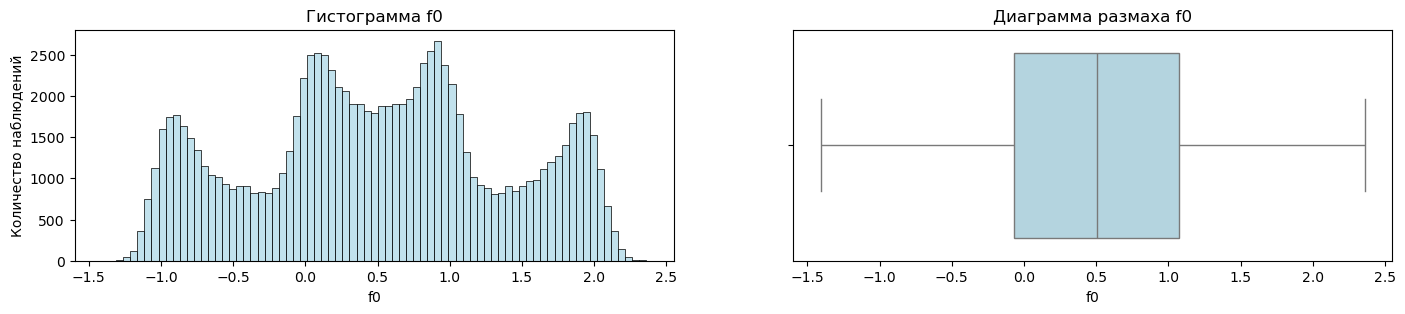

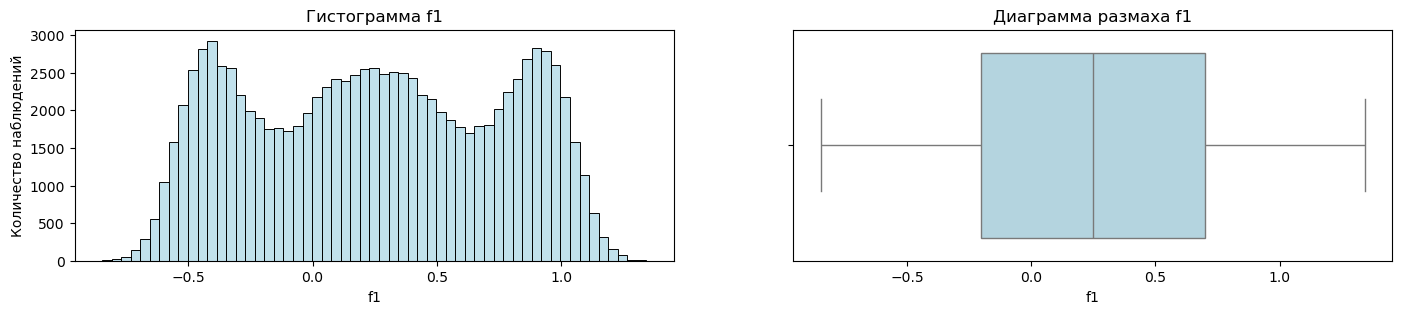

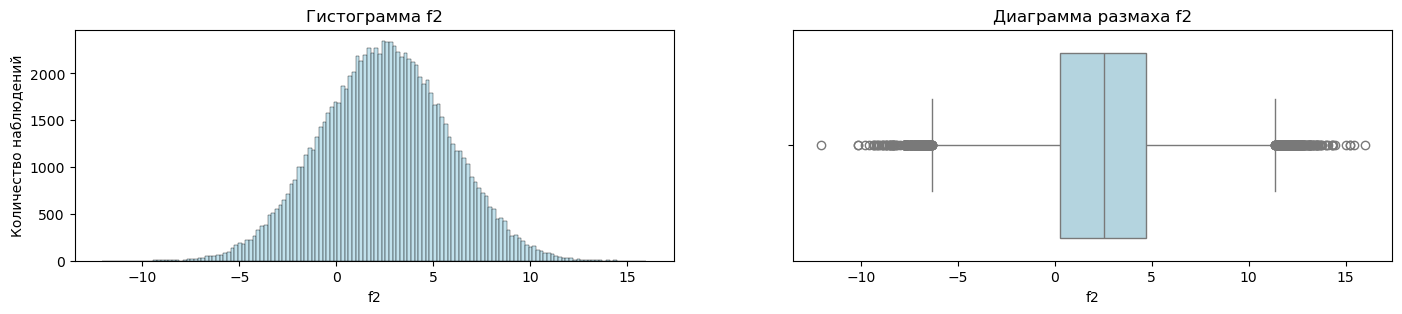

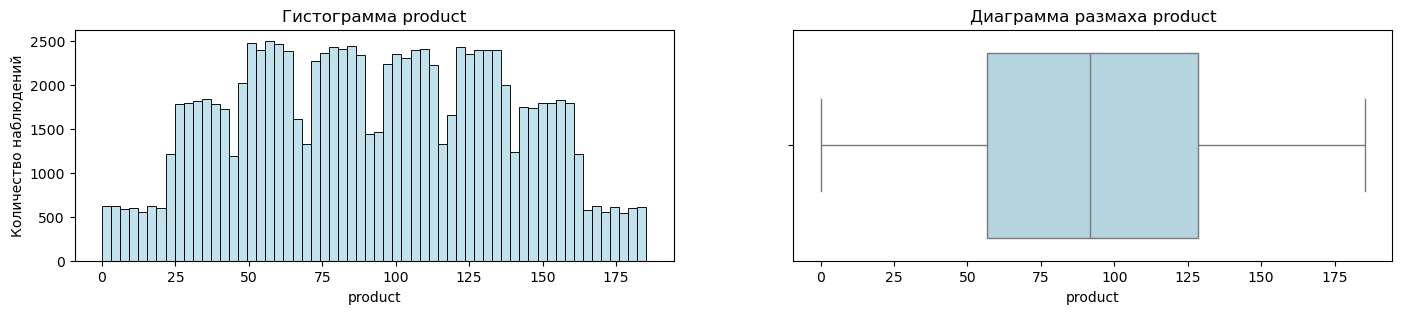

In [13]:
# построим гистограммы и диаграммы размаха
for i in data_col_names:
    hist_box(data_0, i)

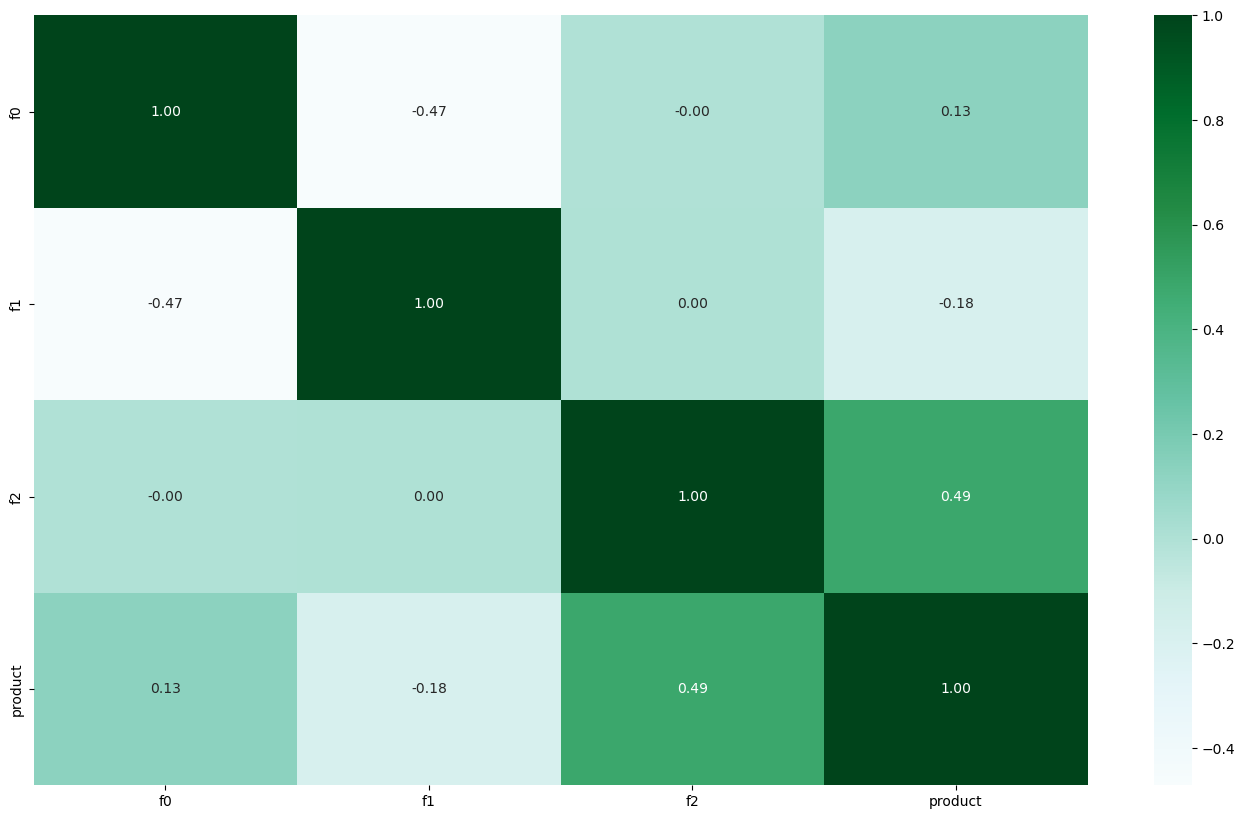

In [14]:
# построим матрицу корреляций
plt.figure(figsize = (17,10))
sns.heatmap(data_0[data_col_names].corr(method="spearman"), annot=True, fmt='.2f', cmap='BuGn');

Распределение признака f2 визуально равномерное. При этом остальные признаки распределены неравномерно.<br>
Для признака f2 боксплот фиксирует большое количество выбросов по обе строны, однако на гистограмме явных выбросов не замечено.<br>
Между признаками f0 и f1 слабая корреляция -0,47. Также слабая корреляция между признаками f2 и product. Другие корреляции малозначительны либо отсутствуют. Мультиколлинеарности признаков не выявлено.

#### Регион 2

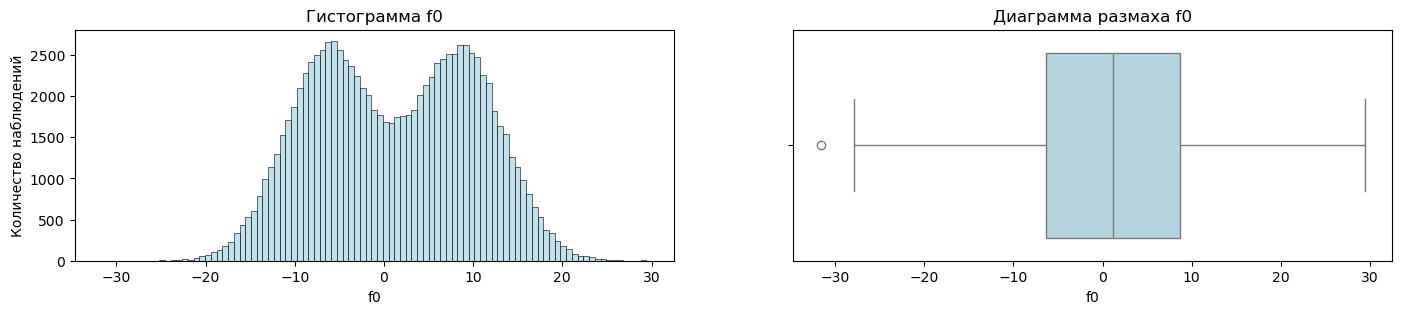

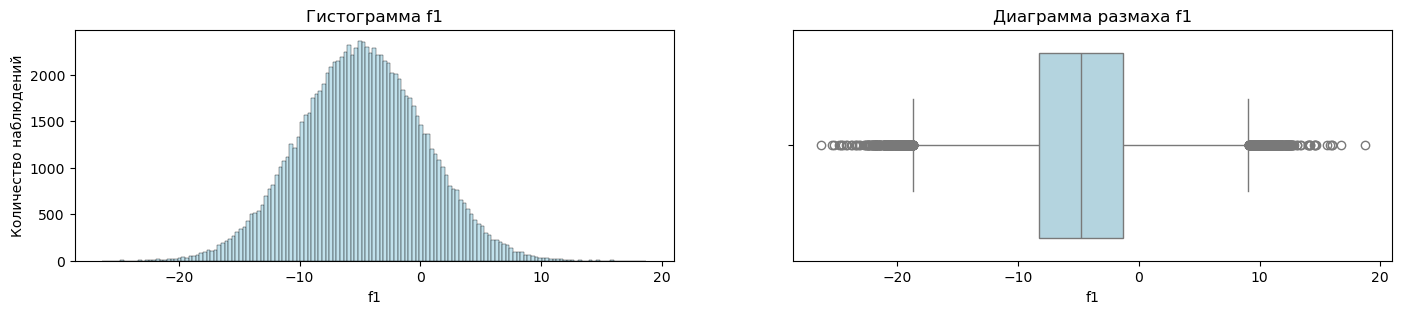

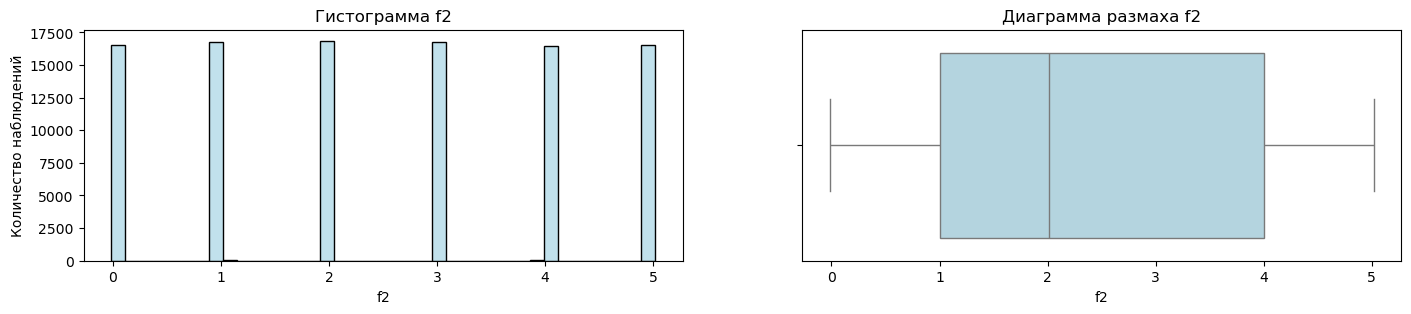

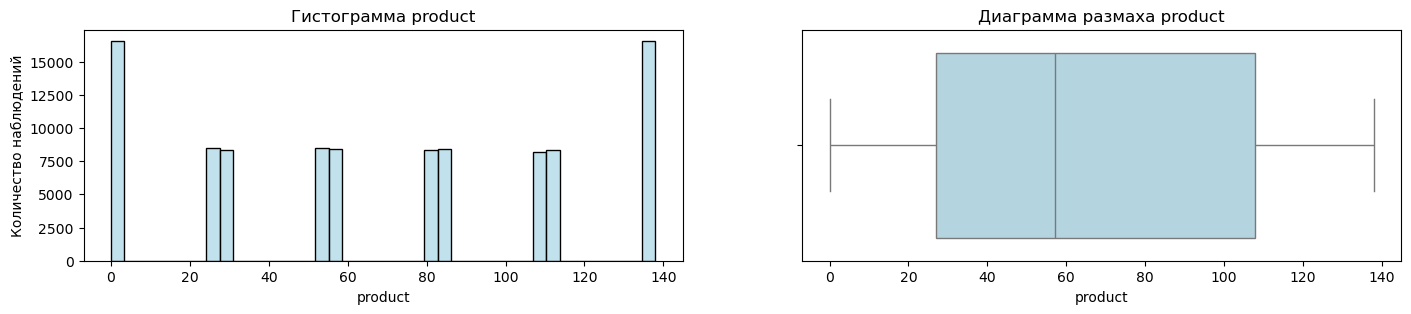

In [15]:
# построим гистограммы и диаграммы размаха
for i in data_col_names:
    hist_box(data_1, i)

In [16]:
# построим матрицу корреляций
plt.figure(figsize = (17,10))
sns.heatmap(data_1.corr(method="spearman"), annot=True, fmt='.2f', cmap='BuGn');

ValueError: could not convert string to float: 'kBEdx'

<Figure size 1700x1000 with 0 Axes>

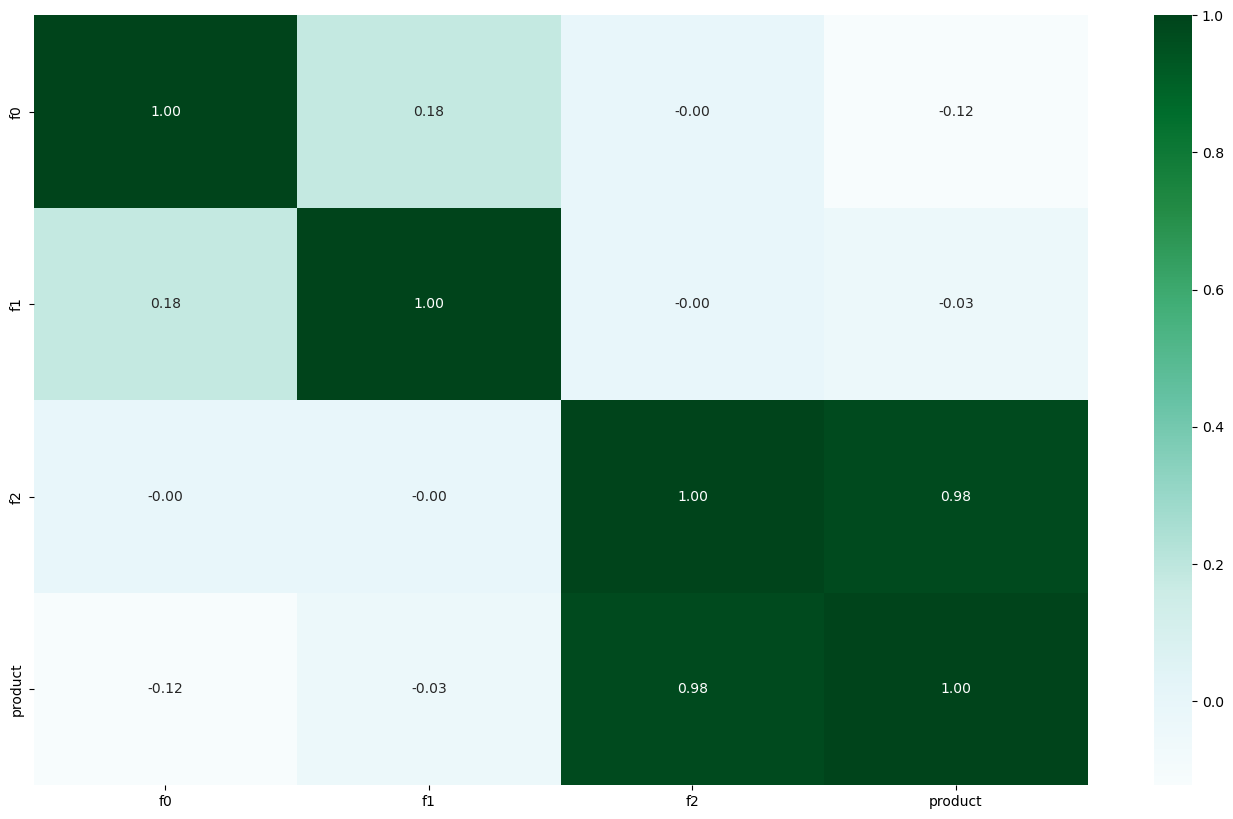

In [17]:
# построим матрицу корреляций
plt.figure(figsize = (17,10))
sns.heatmap(data_1[data_col_names].corr(method="spearman"), annot=True, fmt='.2f', cmap='BuGn');

Признаки f2 и product явно разделяются на отдельные группы значений. У признака f1 визуально нормальное распределение.<br>
Для признака f0 обнаружены единичные выбросы ниже границы, которые теоретически можно было бы исключить. Для признака f1 также обнаружено множество выбросов сверху и снизу от границ, которые скорее являются корректными значениями.<br>
Обнаружена крайне сильная корреляция между признаками f2 и prodact, которая негативно скажется на качестве модели. Между другими признаками корреляции слабые.

#### Регион 3

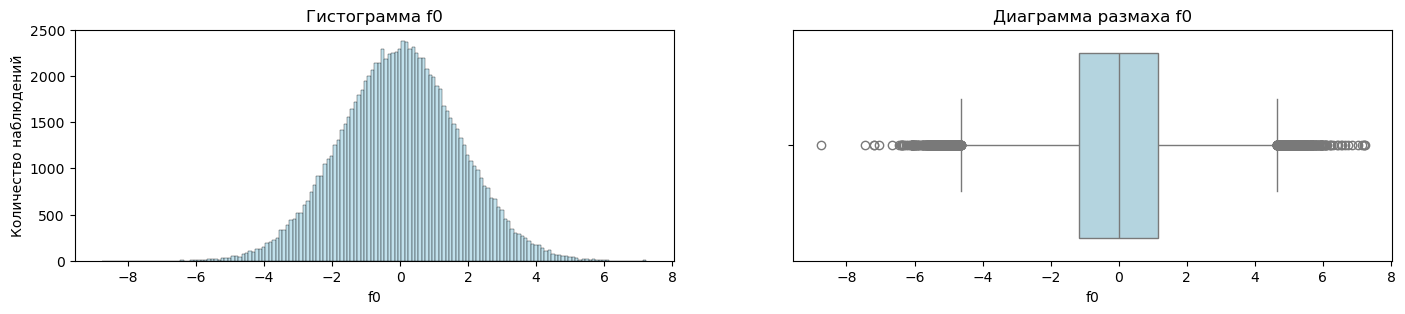

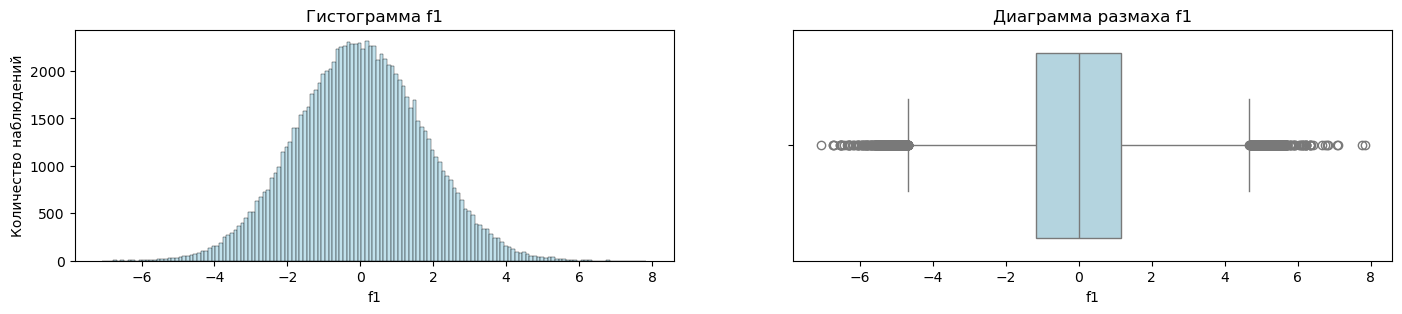

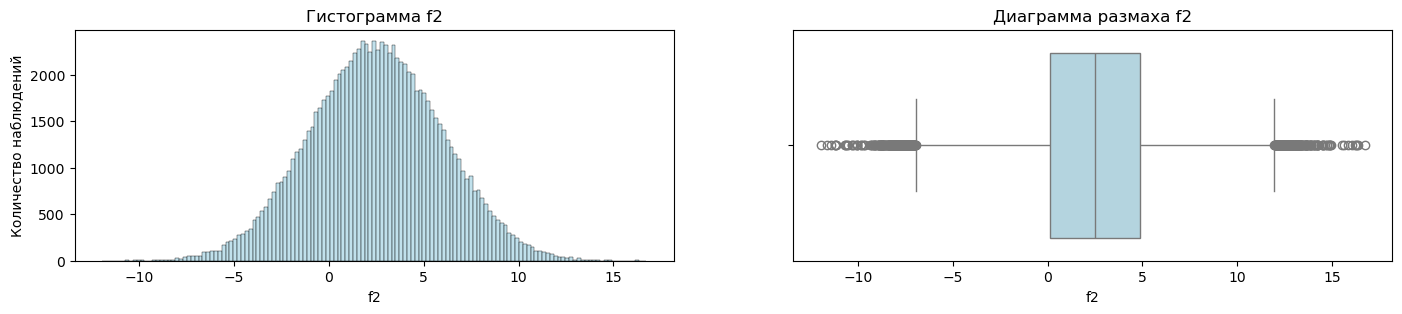

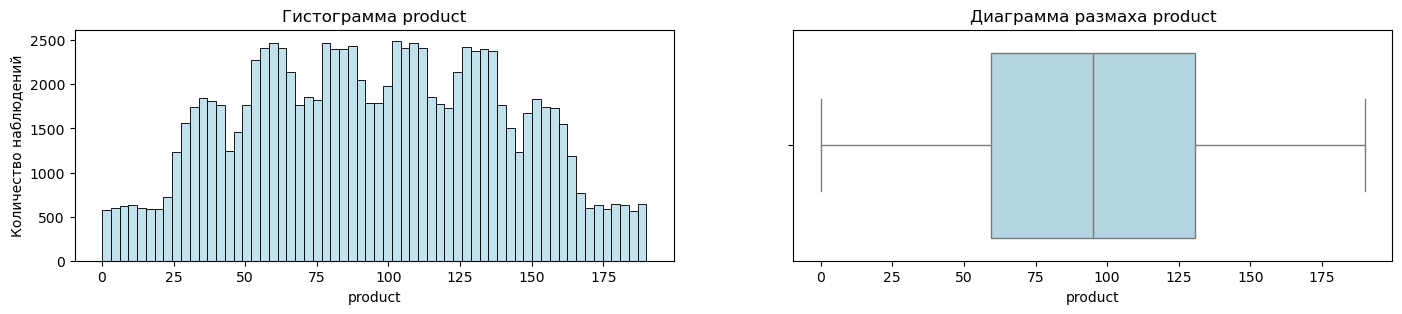

In [18]:
# построим гистограммы и диаграммы размаха
for i in data_col_names:
    hist_box(data_2, i)

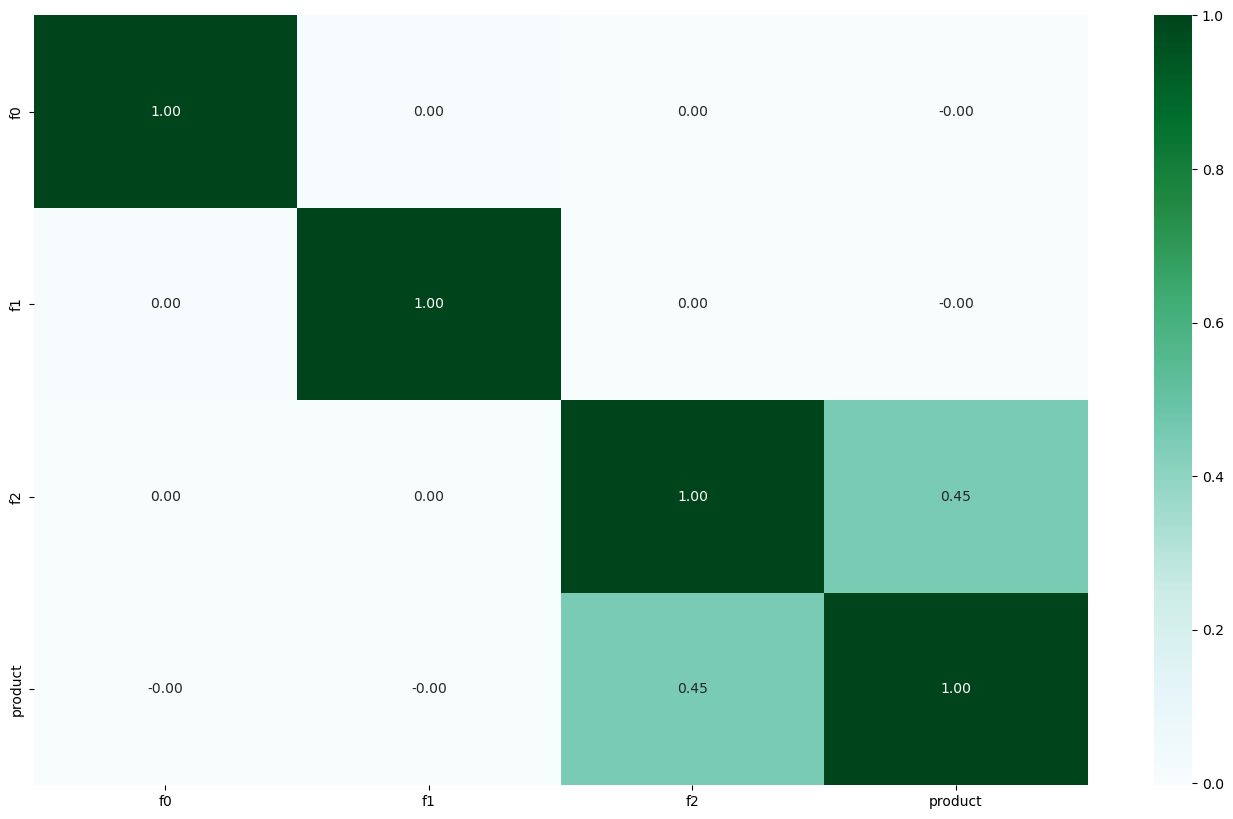

In [19]:
# построим матрицу корреляций
plt.figure(figsize = (17,10))
sns.heatmap(data_2[data_col_names].corr(method="spearman"), annot=True, fmt='.2f', cmap='BuGn');

У признаков f0, f1 и f2 визуально нормальные распределения.<br>
У этих же признаков обнаружены выбросы в обе строны, которые больше похожи на нормальные значения.<br>
Между признаками f2 и product слабая корреляция в 0,45. Между другими признаками корреляции отсутствуют. Мультиколлинеарности не выявлено.

### Вывод по этапу Загрузка и подготовка данных

Данные не требуют обработки пропусков и корректировки типа отдельных переменных. В данных обнаружены повторы в id скважин, при этом внутри повторов указаны разные значения параметров. Мы не знаем, как именно собирались данные (к примеру, там могли оказаться наблюдения по одной скважине за разные периоды), поэтому с повторами ничего не делаем. Однако, этот момент хотелось бы прояснить у коллег, собравших информацию.

В датасете по Региону 2 обнаружена сильная корреляция между f2 и prodact (0,98). Также, некоторые из переменных требуют преобразования в категориальные признаки.

Исходя из того, что выборки синтетические и не предполагают внесения изменений - не будем пока устранять найденные проблемы, однако будем иметь их в виду, как потенциальные "места" для улучшения качества наших моделей.

Признаки f2 и product явно разделяются на отдельные группы значений. У признака f1 визуально нормальное распределение.<br>
Для признака f0 обнаружены единичные выбросы ниже границы, которые теоретически можно было бы исключить. Для признака f1 также обнаружено множество выбросов сверху и снизу от границ, которые скорее являются корректными значениями.<br>
Обнаружена крайне сильная корреляция между признаками f2 и prodact, которая негативно скажется на качестве модели. Между другими признаками корреляции слабые.

#### Регион 3

In [ ]:
# построим гистограммы и диаграммы размаха
for i in data_col_names:
    hist_box(data_2, i)

In [ ]:
# построим матрицу корреляций
plt.figure(figsize = (17,10))
sns.heatmap(data_2.corr(method="spearman"), annot=True, fmt='.2f', cmap='BuGn');

У признаков f0, f1 и f2 визуально нормальные распределения.<br>
У этих же признаков обнаружены выбросы в обе строны, которые больше похожи на нормальные значения.<br>
Между признаками f2 и product слабая корреляция в 0,45. Между другими признаками корреляции отсутствуют. Мультиколлинеарности не выявлено.

### Вывод по этапу Загрузка и подготовка данных

Данные не требуют обработки пропусков и корректировки типа отдельных переменных. В данных обнаружены повторы в id скважин, при этом внутри повторов указаны разные значения параметров. Мы не знаем, как именно собирались данные (к примеру, там могли оказаться наблюдения по одной скважине за разные периоды), поэтому с повторами ничего не делаем. Однако, этот момент хотелось бы прояснить у коллег, собравших информацию.

В датасете по Региону 2 обнаружена сильная корреляция между f2 и prodact (0,98). Также, некоторые из переменных требуют преобразования в категориальные признаки.

Исходя из того, что выборки синтетические и не предполагают внесения изменений - не будем пока устранять найденные проблемы, однако будем иметь их в виду, как потенциальные "места" для улучшения качества наших моделей.

## Обучение и проверка модели

Перед обучением модели проведем кодировку количественных признаков.

In [20]:
# кодировка количественных переменных в первом датасете
data_0 = data_0.drop(['id'], axis=1)
encoder_0 = OrdinalEncoder() 
encoder_0.fit(data_0)
data_ordinal_0 = pd.DataFrame(encoder_0.transform(data_0), columns=data_0.columns)
data_0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [21]:
# кодировка количественных переменных во втором датасете
data_1 = data_1.drop(['id'], axis=1)
encoder_1 = OrdinalEncoder() 
encoder_1.fit(data_1)
data_ordinal_1 = pd.DataFrame(encoder_1.transform(data_1), columns=data_1.columns)
data_1.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [22]:
# кодировка количественных переменных в третьем датасете
data_2 = data_2.drop(['id'], axis=1)
encoder_2 = OrdinalEncoder() 
encoder_2.fit(data_2)
data_ordinal_2 = pd.DataFrame(encoder_2.transform(data_2), columns=data_2.columns)
data_2.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [23]:
# собираем датасеты в список
data = [data_0, data_1, data_2]

Далее - делим датасеты на обучающую и валидационную выборки в соотношении 75:25 и обучим модели. Для этого создадим отдельную функцию.

In [24]:
def work_with_data(data):
    # отделяем целевой признак
    target = data['product']
    features = data.drop(['product'], axis=1)
    # делим на выборки
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=42)

    # обучаем модель
    model=LinearRegression()
    model.fit(features_train,target_train)
    # делаем предсказание
    predict=model.predict(features_valid)
    
    # сохраняем предсказанные значения
    predictions_valid.append(predict)
    # сохраняем среднее предсказанное значение
    predictions_mean.append(round(predict.mean(),0))
    # рассчитываем метрику RMSE
    rmse = mean_squared_error(target_valid, predict)**0.5
    
    # добавим правильные ответы в списки
    true_target.append(target_train.reset_index(drop=True))
    targets_valid.append(target_valid.reset_index(drop=True))
    
    # печатаем вывод
    print('data_%.0f'% n, "; регион ", n+1)
    print('Тренировочная выборка', target_valid.shape[0]/target.shape[0])
    print('Валидационная выборка', target_train.shape[0]/target.shape[0])
    print('RMSE: %.2f'% rmse)
    print('Коэффициент детерминации: %.2f' % r2_score(target_valid, predict))
    print('Средний запас предсказанного сырья: %.2f' % predict.mean())
    print()

In [25]:
# создадим список предсказанного объема сырья на валидационной выборке
predictions_valid = []
# список правильных ответов на валидационной выборке
true_target = []
targets_valid = []
# создадим список средних предсказанных объемов сырья
predictions_mean = []

In [26]:
# применим функцию к датасетам
n = 0
for i in data:
    work_with_data(i)
    n+=1

data_0 ; регион  1
Тренировочная выборка 0.25
Валидационная выборка 0.75
RMSE: 37.76
Коэффициент детерминации: 0.27
Средний запас предсказанного сырья: 92.40

data_1 ; регион  2
Тренировочная выборка 0.25
Валидационная выборка 0.75
RMSE: 0.89
Коэффициент детерминации: 1.00
Средний запас предсказанного сырья: 68.71

data_2 ; регион  3
Тренировочная выборка 0.25
Валидационная выборка 0.75
RMSE: 40.15
Коэффициент детерминации: 0.20
Средний запас предсказанного сырья: 94.77



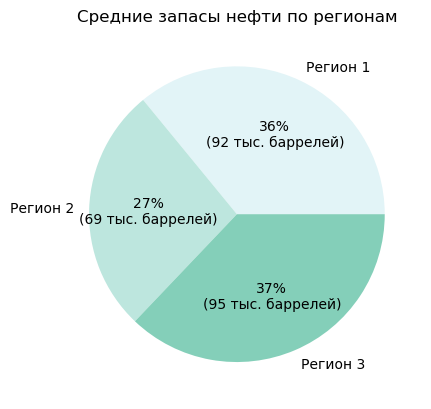

In [27]:
# визуализируем соотношение предсказанного объема сырья
labels = ['Регион 1', 'Регион 2', 'Регион 3']
fig, ax = plt.subplots()
ax.pie(predictions_mean, labels=labels,
      autopct = lambda pct: func(pct, predictions_mean),
      colors=sns.color_palette('BuGn'))
ax.set_title("Средние запасы нефти по регионам")
plt.show();

### Вывод по этапу Обучение и проверка модели

Среди обученных моделей, модель для второго региона (data_1) показывает крайне низкое значение RMSE (0,89), что говорит о ее возможном переобучении. Для устранения переобучения модели следует устранить мультиколлинеарность признаков, а именно высокую корреляцию между f2 и product.<br>
Метрики RMSE двух других моделей (37,76 для региона 1, data_0, и 40,15 для региона 3, data_2) велики в сравнении со средними запасами нефти, что говорит о сильном разбросе данных в валидационных выборках.<br>
По предсказанному объему нефти регион 2 значительно отстает от остальных - 69 тыс. баррелей.

## Подготовка к расчету прибыли

Вынесем данные нам константы в отдельные переменные и рассчитаем необходимые нам показатели.

In [28]:
# бюджет на разработку скважин в регионе, тыс. руб.
BUDGET = 10000000
# доход с каждой единицы продукта, тыс. руб.
INCOME = 450 
# максимально допустимая вероятность убытков
PROBABILITY_LOSSES = 2.5/100

In [29]:
# подсчет бюджета на разработку одной скважины
budget_on_well = (BUDGET/200)
print('Бюджет на разработку одной скважины:', budget_on_well,'тыс.руб')

Бюджет на разработку одной скважины: 50000.0 тыс.руб


In [30]:
# подсчет точки безубыточности для региона
break_even = BUDGET / INCOME
print("Точка безубыточности: {0:.0f} тыс. баррелей на каждый регион.\n". \
      format(break_even))

# подсчет точки безубыточности для скважины
breakeven_volume = break_even / 200
print("Средний объем нефти в скважине, требуемый для безубыточной работы: {0:.0f} тыс. баррелей.". \
      format(breakeven_volume))

Точка безубыточности: 22222 тыс. баррелей на каждый регион.

Средний объем нефти в скважине, требуемый для безубыточной работы: 111 тыс. баррелей.


In [31]:
# подсчет средних запасов сырья по изначальным данным
print('Cредний запас сырья в Регионе 1: %.2f тыс.баррелей'%data_0['product'].mean())
print('Cредний запас сырья в Регионе 2: %.2f тыс.баррелей'%data_1['product'].mean())
print('Cредний запас сырья в Регионе 3: %.2f тыс.баррелей'%data_2['product'].mean())

Cредний запас сырья в Регионе 1: 92.50 тыс.баррелей
Cредний запас сырья в Регионе 2: 68.83 тыс.баррелей
Cредний запас сырья в Регионе 3: 95.00 тыс.баррелей


В каждом из регионов средний запас нефти меньше, чем этого требуется для безубыточной работы: 68,83 - 95 тыс. бар. против 111 тыс. бар.

In [32]:
# добавим доход с каждой скважины в Регионе 1
data_0['profit']=(data_0['product']*(INCOME)).round(2)
data_0.head()

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.221170,105.280062,47376.03
1,1.334711,-0.340164,4.365080,73.037750,32866.99
2,1.022732,0.151990,1.419926,85.265647,38369.54
3,-0.032172,0.139033,2.978566,168.620776,75879.35
4,1.988431,0.155413,4.751769,154.036647,69316.49


In [33]:
# добавим коэффициент ROI в Регионе 1
data_0['roi_%']=((data_0['profit']-budget_on_well)/budget_on_well*100).round(2)
data_0.head()

,f0,f1,f2,product,profit,roi_%
0,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [34]:
print('Разница между безубыточным и средним объемом сырья в Регионе 1: {:.2f}' 
      .format(breakeven_volume - data_0['product'].mean()),
      'тыс. баррелей')

Разница между безубыточным и средним объемом сырья в Регионе 1: 18.61 тыс. баррелей


In [35]:
# добавим доход с каждой скважины в Регионе 2
data_1['profit']=(data_1['product']*(INCOME)).round(2)
data_1.head()

,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,14.272088,-3.475083,0.999183,26.953261,12128.97
2,6.263187,-5.948386,5.001160,134.766305,60644.84
3,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,12.702195,-8.147433,5.004363,134.766305,60644.84


In [36]:
# добавим коэффициент ROI в Регионе 2
data_1['roi_%']=((data_1['profit']-budget_on_well)/budget_on_well*100).round(2)
data_1.head()

,f0,f1,f2,product,profit,roi_%
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [37]:
print('Разница между безубыточным и средним объемом сырья в Регионе 2: {:.2f}' 
      .format(breakeven_volume - data_1['product'].mean()),
      'тыс. баррелей')

Разница между безубыточным и средним объемом сырья в Регионе 2: 42.29 тыс. баррелей


In [38]:
# добавим доход с каждой скважины в Регионе 3
data_2['profit']=(data_2['product']*(INCOME)).round(2)
data_2.head()

,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,0.262778,0.269839,-2.530187,56.069697,25231.36
2,0.194587,0.289035,-5.586433,62.871910,28292.36
3,2.236060,-0.553760,0.930038,114.572842,51557.78
4,-0.515993,1.716266,5.899011,149.600746,67320.34


In [39]:
# добавим коэффициент ROI в Регионе 3
data_2['roi_%']=((data_2['profit']-budget_on_well)/budget_on_well*100).round(2)
data_2.head()

,f0,f1,f2,product,profit,roi_%
0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [40]:
print('Разница между безубыточным и средним объемом сырья в Регионе 3: {:.2f}' 
      .format(breakeven_volume - data_2['product'].mean()),
      'тыс. баррелей')

Разница между безубыточным и средним объемом сырья в Регионе 3: 16.11 тыс. баррелей


Наименьшая разница между безубыточным объемом сырья (111 ты. бар.) и средним объемом (95 тыс. бар.) зафиксирована в Регионе 3.

### Вывод по этапу Подготовка к расчету прибыли

Среднее количество запасов сырья на скважинах всех регионов недостаточно для обеспечения безубыточной разработки. В связи с этим требуется выбрать скважины с максимальными запасами.

## Расчет прибыли и рисков 

Напишем функцию, которая позволит нам выявить 200 лучших скважин в каждом регионе на основе предсказанных запасов сырья, и подсчитать общий объем запасов в этих скважинах и возможную прибыль.

In [41]:
# функция для подсчета суммарного объема сырья и прибыли в 200 лучших скважинах
def region_profit(predict,target):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:200].sum()
    profit_pred=(selected_max*INCOME)-BUDGET
    summ_volume.append(round(selected_max,2))
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объема сырья составит %.2f млн.рублей'%(profit_pred/1000))

In [42]:
# создадим список, в котором сохраним суммарные объемы запасов сырья
summ_volume = []

In [43]:
for i in range(3):
    print('Для Региона', i+1)
    region_profit(predictions_valid[i], targets_valid[i])
    print()

Для Региона 1
Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс.баррелей
Прибыль для полученного объема сырья составит 3896.66 млн.рублей

Для Региона 2
Суммарный запас сырья в 200 лучших скважинах составит: 27748.75 тыс.баррелей
Прибыль для полученного объема сырья составит 2486.94 млн.рублей

Для Региона 3
Суммарный запас сырья в 200 лучших скважинах составит: 29728.85 тыс.баррелей
Прибыль для полученного объема сырья составит 3377.98 млн.рублей



Далее создадим функцию для рассчета прибыли с 200 лучших скважин в каждом регионе.

In [44]:
# функция для подсчета прибыли по 200 лучшим скважинам
def profit_for_region(predict,target):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:200]
    product = selected_points.sum()
    revenue = product * INCOME
    return revenue - BUDGET

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [48]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_region(probs_subsample,target_subsample))  
    
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    # построение графика распределения прибыли
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5), 
                color=sns.color_palette('BuGn'), edgecolor='black')
    plt.axvline(x=values.mean())
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()

    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    # сохраним в списки среднюю прибыль и процент вероятности убытка
    mean_profit.append(round(mean/1000,2))
    loss_probability.append(count/10)

    print("Средняя прибыль: {:.2f} млн.руб"
          .format(mean/1000))
    print('С вероятностью 95% прибыль будет от: {:.2f} млн.руб до: {:.2f} млн.руб'
          .format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб"
          . format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'
           .format(count/1000))

In [49]:
# создадим список с средней прибыль по регионам
mean_profit = []
# создадим список с процентом вероятности убытка по регионам
loss_probability = []

Для Региона 1


  0%|          | 0/1000 [00:00<?, ?it/s]

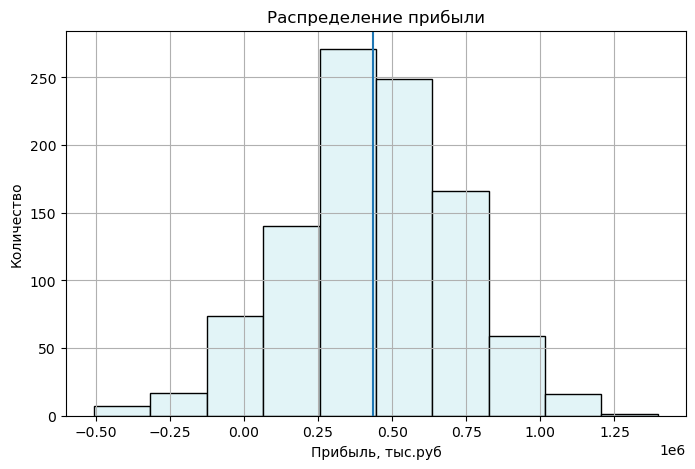

Средняя прибыль: 435.93 млн.руб
С вероятностью 95% прибыль будет от: -116.23 млн.руб до: 966.50 млн.руб
95%-ый доверительный интервал: от 418.76 млн.руб до 453.11 млн.руб
Процент вероятности убытка в данном регионе составит 6.1%

Для Региона 2


  0%|          | 0/1000 [00:00<?, ?it/s]

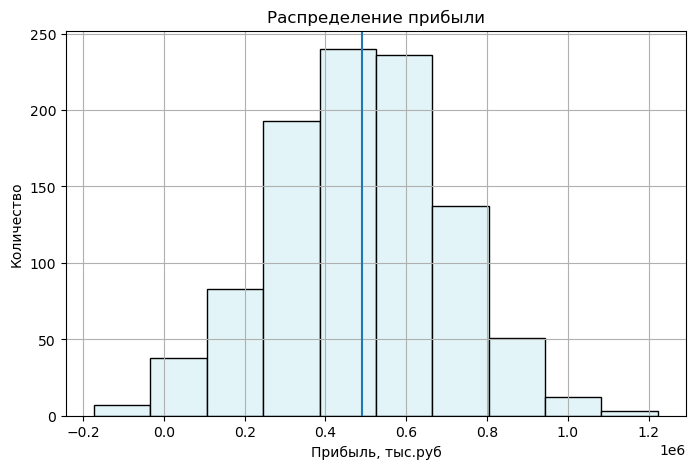

Средняя прибыль: 489.66 млн.руб
С вероятностью 95% прибыль будет от: 55.12 млн.руб до: 905.76 млн.руб
95%-ый доверительный интервал: от 476.23 млн.руб до 503.09 млн.руб
Процент вероятности убытка в данном регионе составит 1.1%

Для Региона 3


  0%|          | 0/1000 [00:00<?, ?it/s]

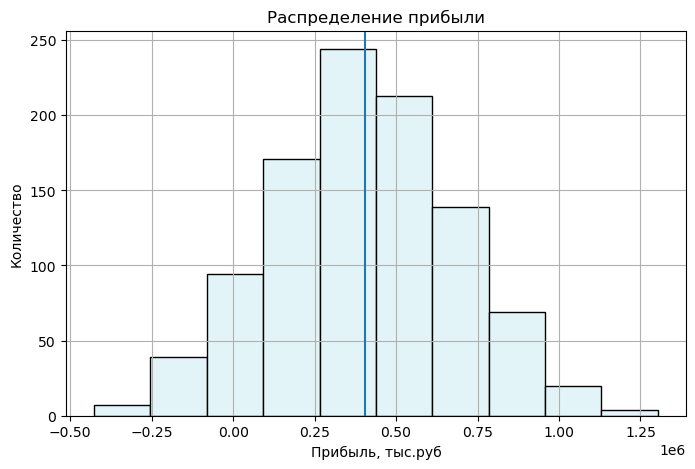

Средняя прибыль: 403.69 млн.руб
С вероятностью 95% прибыль будет от: -153.12 млн.руб до: 952.89 млн.руб
95%-ый доверительный интервал: от 386.21 млн.руб до 421.17 млн.руб
Процент вероятности убытка в данном регионе составит 7.1%



In [50]:
for i in range(3):
    print('Для Региона', i+1)
    bootstap_1000(targets_valid[i],predictions_valid[i])
    print()

In [51]:
# соберем полученную информацию в таблицу
comparison_tab = pd.DataFrame({
    'Средняя прибыль, млн.руб.': mean_profit,
    'Суммарный запас сырья, тыс.бар.': summ_volume,
    'Вероятность убытка, %': loss_probability}).transpose()
comparison_tab.columns = ['Регион 1', 'Регион 2', 'Регион 3']
comparison_tab

,Регион 1,Регион 2,Регион 3
"Средняя прибыль, млн.руб.",435.93,489.66,403.69
"Суммарный запас сырья, тыс.бар.",30881.46,27748.75,29728.85
"Вероятность убытка, %",6.10,1.10,7.10


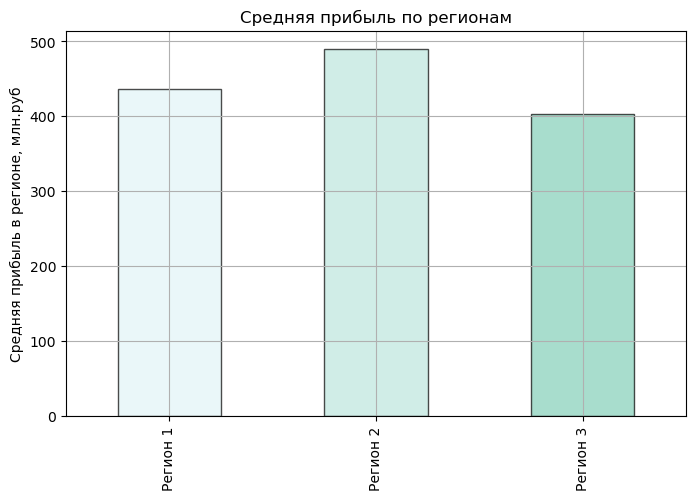

In [52]:
# визуализируем среднню прибыль по регионам
comparison_tab.iloc[0,:].plot(kind="bar", figsize=(8,5), 
                              grid=True, alpha=0.7, 
                              subplots=True, color=sns.color_palette('BuGn'),
                              edgecolor='black')
plt.title('Средняя прибыль по регионам')
plt.ylabel('Средняя прибыль в регионе, млн.руб')
plt.show()

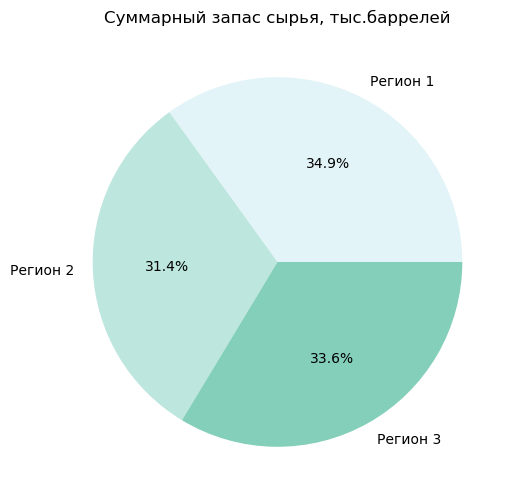

In [53]:
# визуализируем суммарный запас сырья в регионах
comparison_tab.iloc[1,:].plot(kind='pie', figsize=(6,6),
                              autopct='%1.1f%%', subplots=True,
                              colors=sns.color_palette('BuGn'))
plt.title('Суммарный запас сырья, тыс.баррелей')
plt.ylabel('')
plt.show()

### Вывод по этапу Расчет прибыли и рисков

Для разработки планируется отобрать 200 лучших скважин. Было выбрано по 200 скважин с наибольшими предсказанными запасами сырья в каждом регионе. Для этих скважин рассчитаны объем запасов сырья и возможная прибыль.

Регионом, в котором вероятность убытков меньше 2.5% является только Регион 2.<br>
В то же время, в Регионе 2 наименьший суммарный запас сырья - 27748,75 тыс. баррелей. Однако, по размеру потенциальной прибыли он лидирует: прогнозируется прибыль в 489,66 млн. руб.

## Выводы

1. <b>Загрузка и подготовка данных:</b>
* Были импортированы и проанализированы данные в трех датасетах по регионам. Внутри каждого датасета 100000 наблюдений. При первичном анализе обнаружены дубликаты в переменной ID.
* Корреляционный анализ выявил сильную корреляцию между признаками f2 и prodact (0,98).
2. <b>Обучение и проверка модели:</b>
* Были созданы и обучены 3 модели линейной регрессии. Для данных Региона 2 модель показывает крайне низкое значение RMSE (0,89) в связи с переобучением.
* Исходя из предсказаний моделей, лидером по общему объему сырья является Регион 3 (95 тыс. баррелей). Для Региона 2 предсказаны наименьшие запасы сырья (69 тыс. баррелей).
3. <b>Подготовка к расчету прибыли:</b>
* Были зафиксированы основные вводные метрики.
* Был рассчитан бюджет на разработку одной скважины, а также объем для безубыточного производства для региона и для скважины.
* Среднее количество запасов сырья на скважинах всех регионов недостаточно для обеспечения безубыточной разработки.
* Наименьшая разница между безубыточным объемом сырья и средним объемом зафиксирована в Регионе 3 (16,11 тыс. баррелей).
4. <b>Расчет прибыли и рисков:</b>
* Было отобрано по 200 лучших скважин в каждом регионе.
* Для дальнейшей разработки рекомендуется выбрать Регион 2, не смотря на то, что в нем меньшие запасы сырья (27748,75 тыс. баррелей). Выбор обоснован тем, что в данном регионе прогнозируется наибольшая прибыль (489,66 млн. руб.), а также тем, что это единственный регион с вероятностью убытков менее 2,5% (1,1%).

<b>Потенциал для улучшения выводов:</b>
* Прояснить причины дублирования ID скважин в каждом из датасетов.
* Проанализировать зафиксированные выбросы в датасете Региона 2 в переменной f0.
* Для построения модели линейной регрессии устранить мультиколлинеарность признаков, привести некоторые из переменных в категориальный формат.